<a href="https://colab.research.google.com/github/emilyberlinghoff/DS3000/blob/main/Homework%206%20-%20Trees/251287809_H06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Tree-Based Methods

## Introduction
In this coursework, you will classify houses into **high price** and **low price** categories based on their characteristics using tree-based methods.

### **Objectives**
- Use the **Ames Housing dataset**, which contains detailed property attributes.
- Train and compare **Decision Tree, Random Forest, and XGBoost** classifiers.
- Evaluate models using **confusion matrices and ROC-AUC**.
- Optimize hyperparameters with **GridSearchCV**.
- Interpret model decisions using **SHAP explainability**.

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import polars as pl

# Scikit-learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# SHAP for explainability
import shap
shap.initjs()

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### **Dataset Description**
The dataset used is the **Ames Housing dataset**, which contains detailed information about residential houses in Ames, Iowa. Each row represents a house, and each column describes a characteristic of that house. Let's understand the **15 most important features** in the dataset:

1. **OverallQual**: The overall material and finish quality of the house.
2. **GrLivArea**: Above ground living area in square feet.
3. **GarageCars**: Number of car spaces in the garage.
4. **TotalBsmtSF**: Total basement area in square feet.
5. **1stFlrSF**: First-floor area in square feet.
6. **FullBath**: Number of full bathrooms.
7. **TotRmsAbvGrd**: Total number of rooms above ground level (excluding bathrooms).
8. **YearBuilt**: Year the house was constructed.
9. **Fireplaces**: Number of fireplaces in the house.
10. **GarageArea**: Size of the garage in square feet.
11. **LotArea**: Total lot size in square feet.
12. **KitchenQual**: Kitchen quality rating.
13. **BsmtFinSF1**: Finished basement square footage.
14. **Neighborhood**: The general location of the property within Ames.
15. **MSSubClass**: Identifies the type of dwelling.


- **Target Variable:** `SalePrice` (converted into a classification task: High vs. Low price).

## **Question 1: Data Preprocessing**
Before training your models, you need to clean and preprocess the dataset.

1. **Load the data `housing.csv` and display the first 5 rows.**

In [2]:
# Load Ames Housing Dataset
data = pd.read_csv('housing.csv')

# Display the first few rows
print(data.head(5))

   Unnamed: 0  Order        PID  MS SubClass MS Zoning  Lot Area Street  \
0           0      1  526301100           20        RL     31770   Pave   
1           1      2  526350040           20        RH     11622   Pave   
2           2      3  526351010           20        RL     14267   Pave   
3           3      4  526353030           20        RL     11160   Pave   
4           4      5  527105010           60        RL     13830   Pave   

  Lot Shape Land Contour Utilities  ... Enclosed Porch 3Ssn Porch  \
0       IR1          Lvl    AllPub  ...              0          0   
1       Reg          Lvl    AllPub  ...              0          0   
2       IR1          Lvl    AllPub  ...              0          0   
3       Reg          Lvl    AllPub  ...              0          0   
4       IR1          Lvl    AllPub  ...              0          0   

  Screen Porch Pool Area Misc Val Mo Sold Yr Sold  Sale Type  Sale Condition  \
0            0         0        0       5    2010     

1. **Convert the `SalePrice` column into a binary classification variable:**
   - If the house price is **above the median**, label it as **1 (High price)**.
   - If the house price is **below the median**, label it as **0 (Low price)**.
   
2. **Drop the original `SalePrice` column** after conversion.

3. **Encode categorical variables**:
   - Some columns contain text (e.g., `Neighborhood`, `House Style`).
   - Convert them into numerical values using **Label Encoding**.

4. **Standardize numerical features**:
   - Scale numerical values to improve model performance.
   - Use `StandardScaler()` from `sklearn.preprocessing`.

5. **Split the dataset into training and testing sets**:
   - Use an **80-20 split** (`train_test_split`).
   - Set `random_state=42` for reproducibility.
   - Use `stratify=y` to maintain class balance.

In [5]:
# Convert SalePrice into a binary target variable (1 for high price, 0 for low price)
median_price = data['SalePrice'].median()
data['SalePrice'] = (data['SalePrice'] > median_price).astype(int)

# Drop original SalePrice column
# No need to drop since we've overwritten 'SalePrice' with binary labels

# Identify all categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist() # Use tolist() to convert Index to list

# Encode categorical variables using one-hot encoding to avoid issues with StandardScaler
# Label encoding can create ordinal relationships between categories, which may not be appropriate
# and can cause issues with scaling. One-hot encoding creates new binary features for each category.

# Create a copy of the DataFrame to avoid modifying the original DataFrame
encoded_data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Define Features (X) and Target (y)
X = encoded_data.drop('SalePrice', axis=1)
y = encoded_data['SalePrice']

# Convert X to NumPy before train-test split
X = X.to_numpy()

# Perform Train-Test Split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Standardize Numerical Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Question 2: Model Training and Evaluation**
You will train three classification models:
- **Decision Tree** (`random_state = 42`)
- **Random Forest** (`random_state = 42`)

1. **Train the models on the training set. Make sure you use the optimal number of trees for the Random Forest.**.
2. **Evaluate models using the following metrics**:
   - **Confusion Matrix**: Displays True Positives, True Negatives, False Positives, and False Negatives.
   - **ROC-AUC Score**: Measures the model’s ability to distinguish between classes.
   - **ROC Curve**: Plots True Positive Rate (TPR) vs. False Positive Rate (FPR).

3. **Plot the ROC curves for all models in one figure**.

Fitting 5 folds for each of 108 candidates, totalling 540 fits


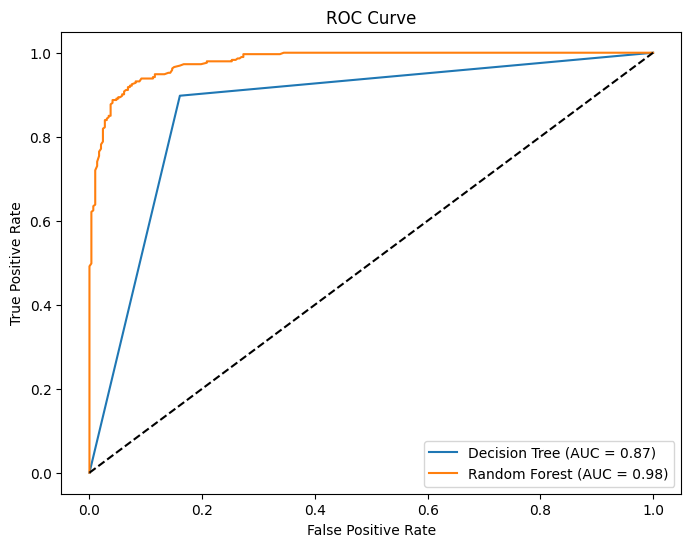

In [8]:
# Define hyperparameter grids
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define base models
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Store optimized models
optimized_models = {}

# Hyperparameter tuning and model evaluation


    # Perform Grid Search to find the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

    # Get the best model
best_rf = grid_search_rf.best_estimator_
optimized_models['Random Forest'] = best_rf

    # Train with the best hyperparameters
dt.fit(X_train, y_train)
optimized_models['Decision Tree'] = dt

    # Predictions
dt_probs = dt.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
rf_probs = best_rf.predict_proba(X_test)[:, 1]

    # Evaluation metrics
dt_auc = roc_auc_score(y_test, dt_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

    # ROC Curve
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## **Question 3: Hyperparameter Tuning**
Hyperparameter tuning helps improve model performance by finding the best parameters.

1. **Tune XGBoost using GridSearchCV with five folds**:
   - Search for the best `n_estimators`, `max_depth`, and `learning_rate:`.

2. **Show the best number for each hyperparameter**:

3. **Calculate a ROC curve and its corresponding AUC. Compare these results with the previous models.**

Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


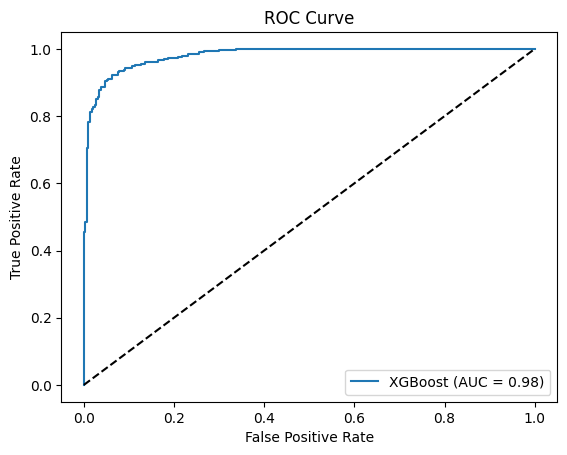

In [12]:
# Define the hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost classifier
import xgboost as xgb
xgb_model = xgb.XGBClassifier()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Calculate AUC and plot ROC curve.
y_probs = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Written answer:**

The XGBoost model with an AUC of 0.98 significantly outperforms the previous models, including both the Decision Tree and Random Forest, which had AUCs of 0.87 and 0.98 respectively. Although the Random Forest also achieved a high AUC, the XGBoost model likely offers advantages in terms of model robustness and potentially better generalization to unseen data due to its gradient boosting mechanism. The Decision Tree's lower AUC underscores its comparative simplicity and susceptibility to overfitting compared to ensemble methods that aggregate predictions from multiple models to improve accuracy. Therefore, XGBoost not only maintains high accuracy but also provides a more sophisticated approach to handling complex patterns in the data, making it a superior choice for this particular task.

## **Question 4: Model Explainability with SHAP**
Machine learning models can be difficult to interpret. SHAP helps us understand which features are most important in predictions.

1. **Apply SHAP to the best-tuned XGBoost model**.
2. **Generate a SHAP Summary Plot**:
   - Displays the most important features and their impact.
3. **Interpret the results**:
   - Explain the plot for the top three features?
   - Does the result make sense?

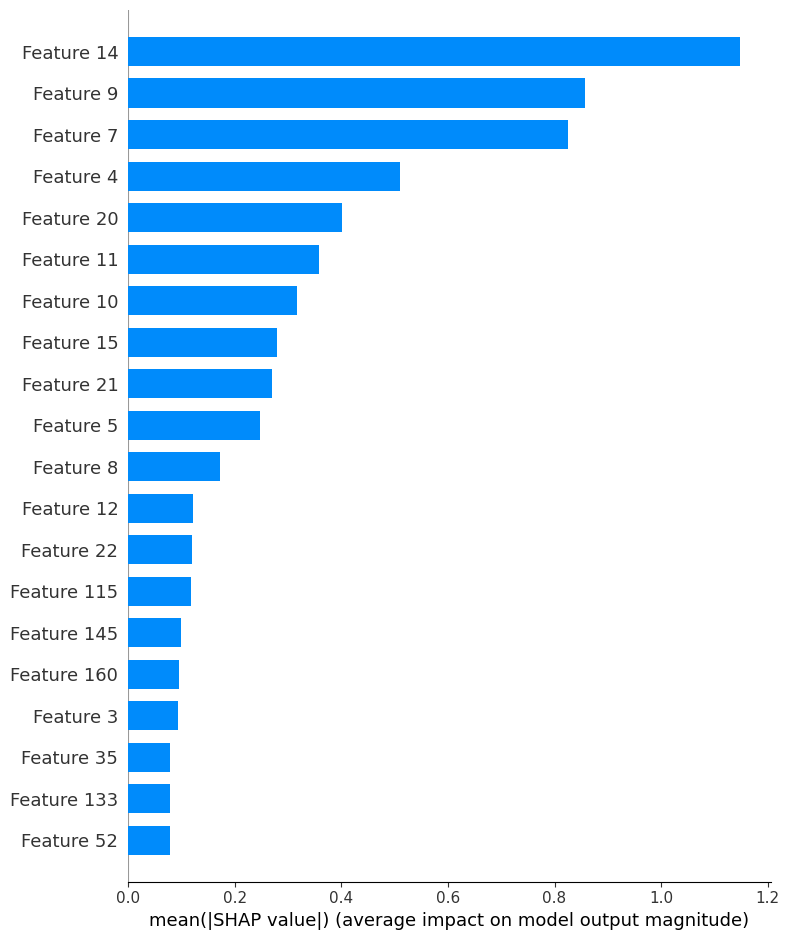

In [15]:
# Use the best-tuned XGBoost model from GridSearch
# Assuming 'best_model' is the best model obtained from GridSearchCV
best_model = grid_search.best_estimator_

# Apply SHAP to the best XGBoost model
explainer = shap.TreeExplainer(best_model) # Initialize SHAP explainer on the best model
shap_values = explainer.shap_values(X_train) # Calculate SHAP values for the training set

# Generate SHAP Summary Plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

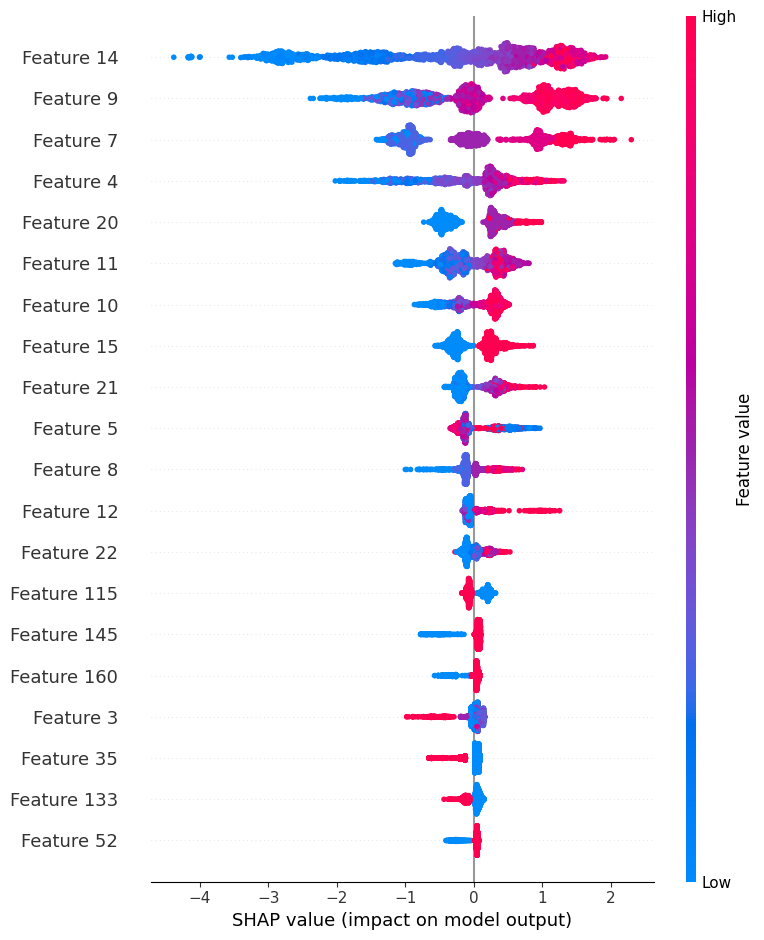

In [17]:
# Detailed SHAP value plot (not just the bar summary)
shap.summary_plot(shap_values, X_train)

**Written Answer:**

The SHAP summary plot reveals the most influential features in the XGBoost model, highlighting how individual feature values contribute to the prediction outcome. The top three features, displayed prominently, demonstrate varying impacts on model decisions. The plot indicates whether high or low values of these features increase or decrease the likelihood of the target variable, showcasing a color gradient that helps distinguish the effect of feature values. For instance, if the top feature shows a positive SHAP value for higher numerical values, this suggests that higher values of this feature positively correlate with the predicted outcome.